# Maximize the likelihood using iminuit (CMB parameterization)

See tutorials here: https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.likelihood import likelihood
from lace.likelihood import full_theory
from lace.likelihood import CAMB_model
from lace.cosmo import camb_cosmo
from lace.sampler import iminuit_minimizer
from lace.sampler import emcee_sampler
import time

### Note that this minimiser is quite fragile, it only works when starting near the truth

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label='central'
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max_data=4
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max_data,pivot_scalar=0.05)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


In [4]:
# access true cosmology in simulation, will be used later
sim_cosmo=data.mock_sim.sim_cosmo

Setup archive of P1D measurements from simulations to train the emulator

In [5]:
# Set up emulator training set
z_max_emu=4
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max_emu,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [6]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max_emu,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [7]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,true_camb_model=camb_model_sim,use_camb_fz=True)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,use_camb_fz=True)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.true_camb_model.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [8]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[-0.1, 0.1],[-0.5, 0.5],[-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.1, 0.1]]
#    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
#    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.1, 0.1],
#            [-0.5, 0.5], [-0.2, 0.2]]

In [9]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,prior_Gauss_rms=0.5)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
starting chi2 3.89609405908804


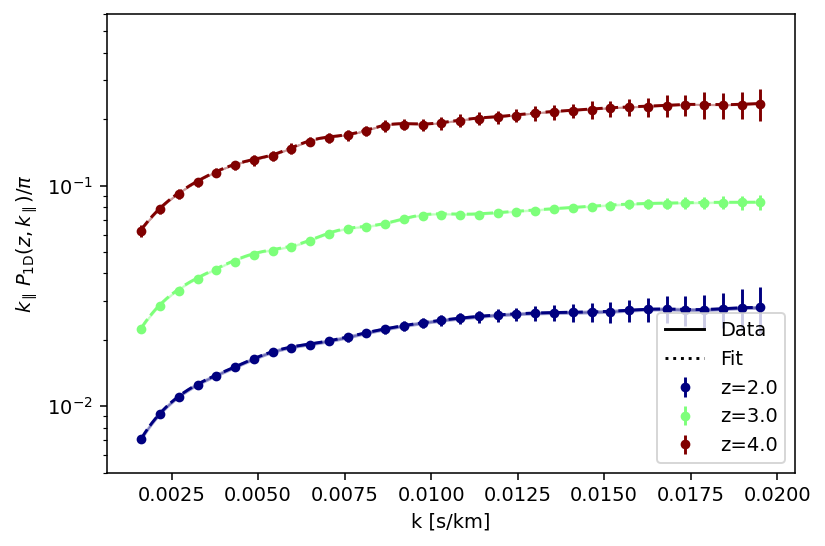

In [10]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)
like.plot_p1d(plot_every_iz=4)

## Setup our own minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [12]:
minimizer.minimize()

will run migrad
------------------------------------------------------------------
| FCN = -24.65                  |      Ncalls=70 (70 total)      |
| EDM = 1.28e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
will compute Hessian matrix


best-fit values = [0.49584486 0.43561591 0.51363006]


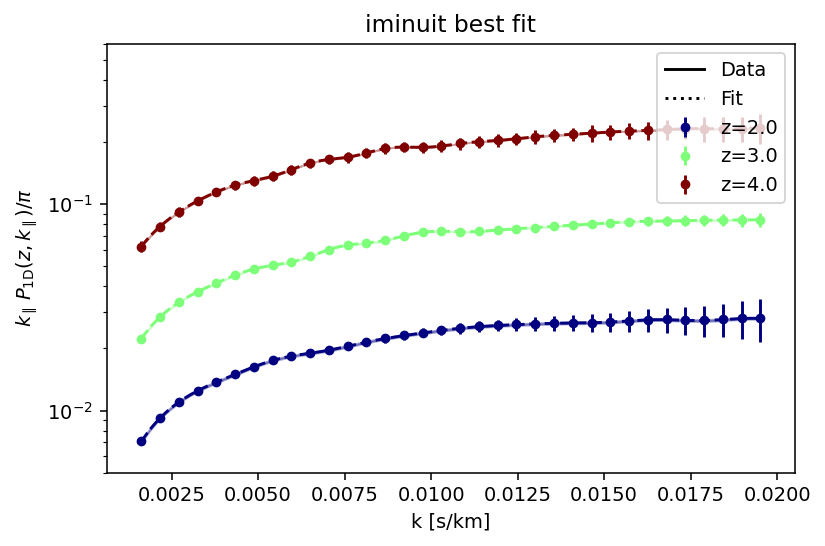

In [13]:
minimizer.plot_best_fit(plot_every_iz=4)

### Plot Gaussian contours after minimization

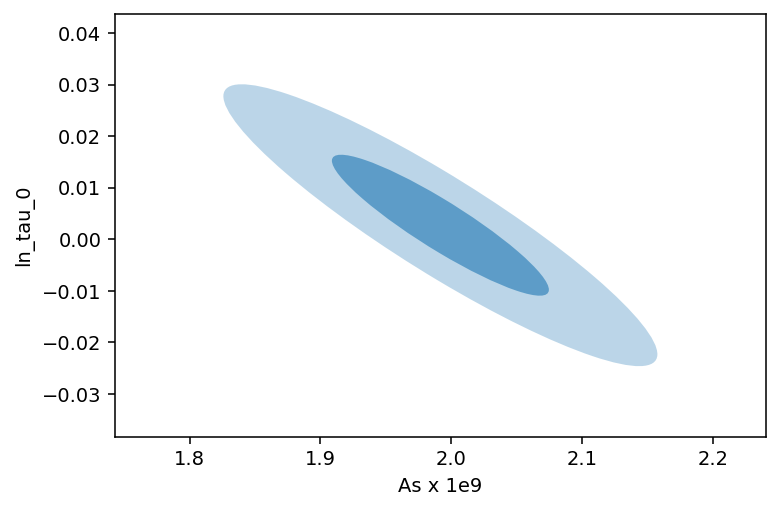

In [14]:
minimizer.plot_ellipses('As','ln_tau_0',cube_values=False) 

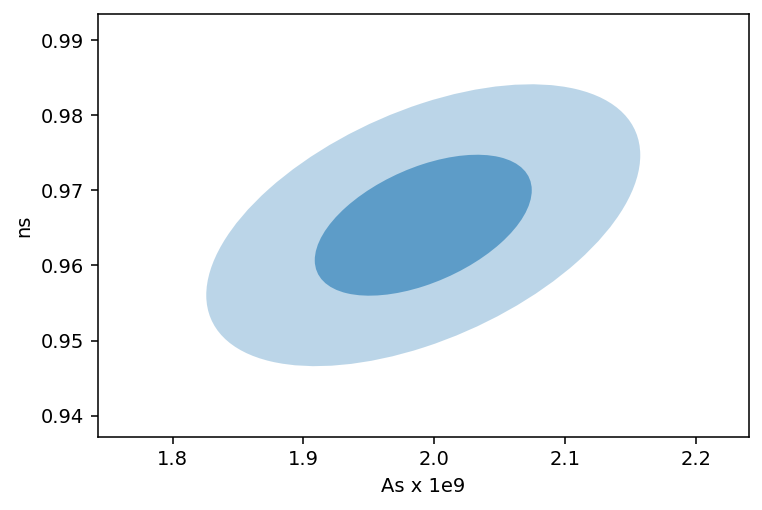

In [15]:
minimizer.plot_ellipses('As','ns',cube_values=False) 

In [16]:
if False:
    # compare with function from iminuit
    minimizer.plot_ellipses('As','ns',cube_values=True) 
    # this will take a while, it computes several minimizations
    minimizer.minimizer.draw_mncontour('x0','x1',numpoints=20)

## Run the emcee sampler

In [17]:
## Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,
                        free_param_names=like_params,verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

In [18]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1e-09 3e-09
ns 0.965 0.9 1.05
ln_tau_0 0.0 -0.1 0.1


In [19]:
n_burn_in=50
n_steps=500 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████| 550/550 [03:19<00:00,  2.76it/s]

Sampling took 199.8 seconds


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/lace-1.0.1-py3.8.egg/lace/sampler/emcee_sampler.py:740: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


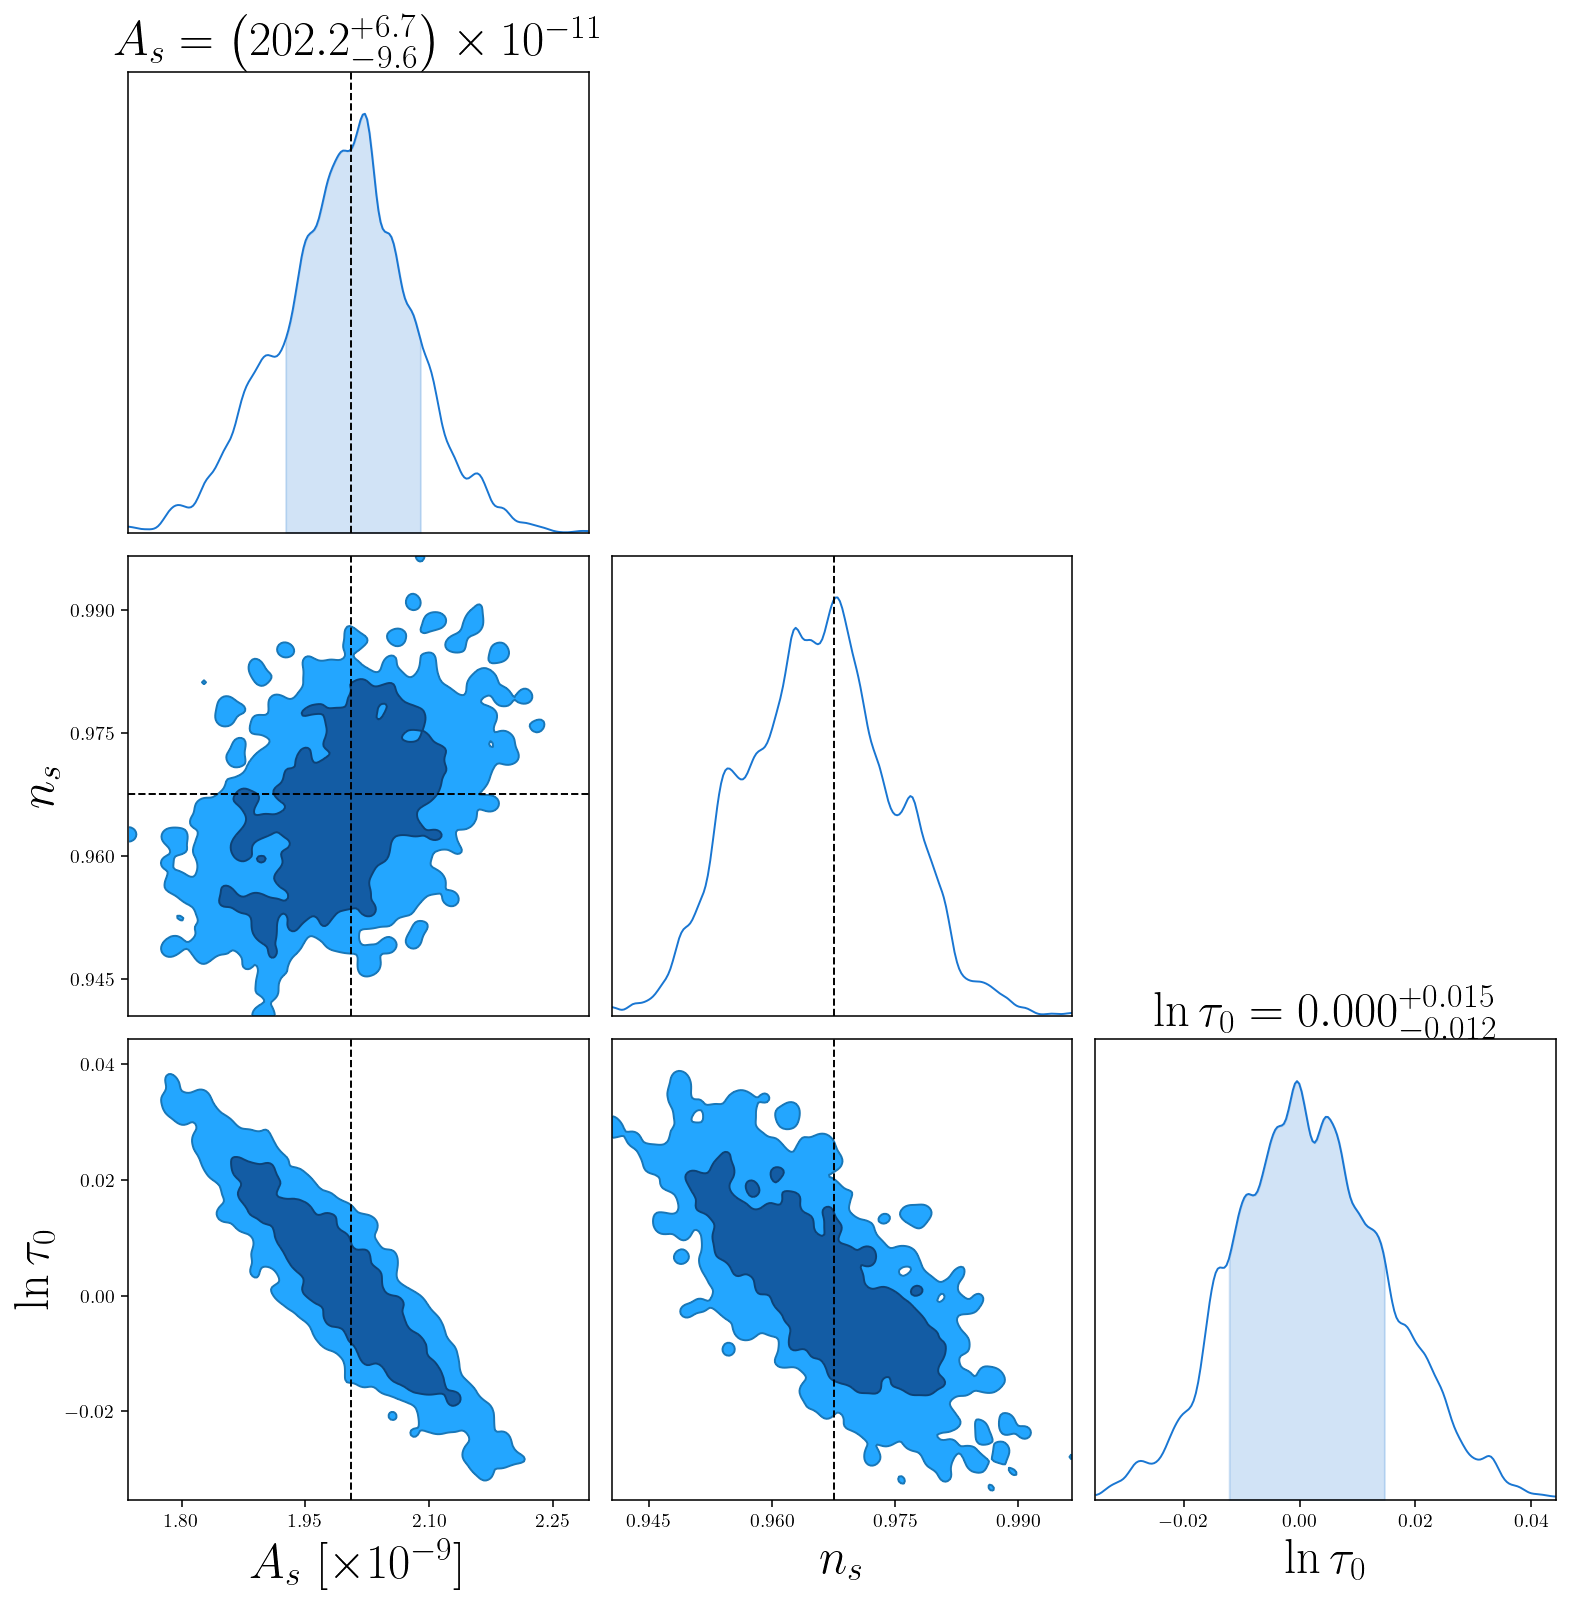

In [20]:
sampler.plot_corner()

In [21]:
chain,ln_prob=sampler.get_chain(cube=False)

In [22]:
np.mean(chain,axis=0)

array([1.99673606e-09, 9.65778026e-01, 1.99817022e-03])

In [42]:
np.sqrt(np.var(chain,axis=0))

array([8.14254229e-11, 8.93359696e-03, 1.32812308e-02])

In [23]:
camb_cosmo.print_info(sim_cosmo)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


In [40]:
minimizer.best_fit_value(pname='As',return_hesse=True)

cube values = [0.49584486 0.43561591 0.51363006]


(1.9916897110546126e-09, 8.294697659340894e-11)

In [43]:
minimizer.best_fit_value(pname='ns',return_hesse=True)

cube values = [0.49584486 0.43561591 0.51363006]


(0.9653423865390071, 0.00937256857985812)

In [44]:
minimizer.best_fit_value(pname='ln_tau_0',return_hesse=True)

cube values = [0.49584486 0.43561591 0.51363006]


(0.0027260112717179402, 0.013667011194800575)

## Run iminuit minimiser directly (without using our object)

In [24]:
from iminuit import Minuit

In [25]:
# setup iminuit
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [26]:
# run optimiser
m.migrad()

------------------------------------------------------------------
| FCN = -24.65                  |      Ncalls=70 (70 total)      |
| EDM = 1.28e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.50    |   0.04    |            |            |         |         |       |
| 1 | x1   |   0.44    |   0.06    |            |            |         |         |       |
| 2 | x2   |   0.51    |   0.07    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [27]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7feaefa50b70>
  x0: 0.4958448555273064
  x1: 0.43561591026004687
  x2: 0.5136300563585897


------------------------------------------------------------------
| FCN = -24.65                  |      Ncalls=70 (70 total)      |
| EDM = 1.28e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

In [28]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 0.13482509489929628
As = 1.9916897110546126e-09
ns = 0.9653423865390071
ln_tau_0 = 0.0027260112717179402


In [29]:
# compare to truth
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 2.006055e-09
true ns = 0.967565


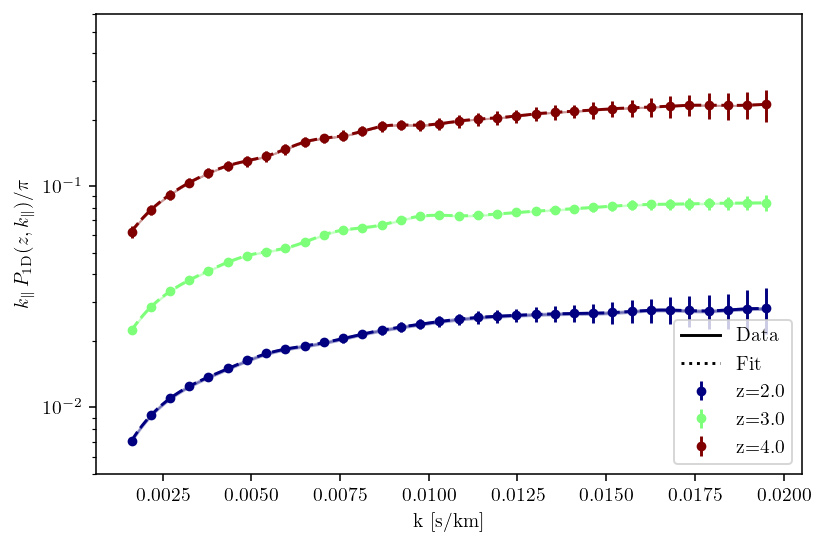

In [30]:
like.plot_p1d(plot_every_iz=4,values=m.values)

# Other cool things we can do with iminuit

In [31]:
# get Gaussian approximated errors
m.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.50    |   0.04    |            |            |         |         |       |
| 1 | x1   |   0.44    |   0.06    |            |            |         |         |       |
| 2 | x2   |   0.51    |   0.07    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [32]:
# get proper errors from likelihood scans
m.minos()

-------------------------------------------------
|       x0        |            Valid            |
-------------------------------------------------
|      Error      |    -4e-2     |     4e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x1        |            Valid            |
-------------------------------------------------
|      Error      |    -6e-2     |     6e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x2        |            Valid            |
-------------------------------------------------
|      Error      |    -7e-2     |     7e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [33]:
# get best-fit values
m.np_values()

array([0.49584486, 0.43561591, 0.51363006])

In [34]:
like.get_free_parameter_list()

['As', 'ns', 'ln_tau_0']

In [35]:
# get parameters covariance
m.np_covariance()

array([[ 0.00172005,  0.00128566, -0.00259443],
       [ 0.00128566,  0.00390422, -0.00327466],
       [-0.00259443, -0.00327466,  0.00466968]])

(array([0.31064833, 0.3384189 , 0.36618948, 0.39396005, 0.42173062,
        0.4495012 , 0.47727177, 0.50504234, 0.53281292, 0.56058349]),
 array([-22.46307893, -23.35659151, -24.0054596 , -24.42411882,
        -24.62698592, -24.62743286, -24.43721167, -24.0661758 ,
        -23.52219619, -22.81172617]))

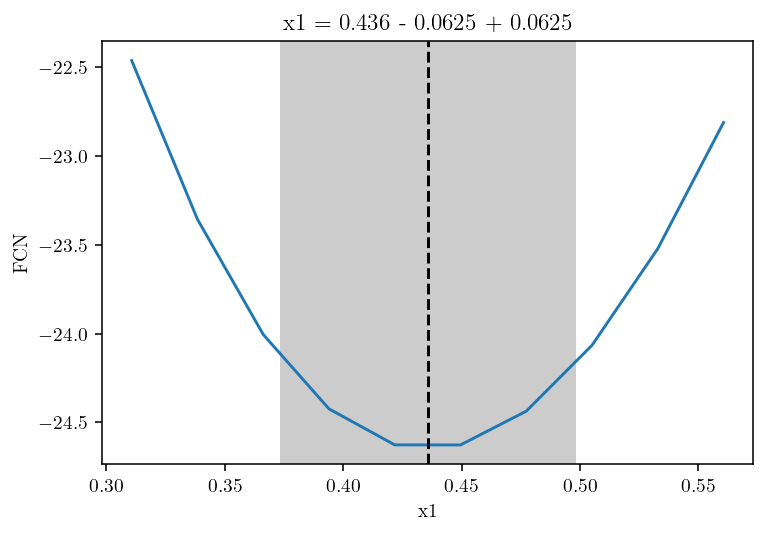

In [36]:
# scan one parameter and plot minus log posterior
m.draw_mnprofile(vname='x1',bins=10)

In [37]:
# for another parameter
m.draw_mnprofile(vname='x3',bins=10)

ValueError: Unknown parameter x3

In [ ]:
# 2D contours
m.draw_contour('x0','x1',bins=20)

In [ ]:
# matrix correlations
m.matrix(correlation=True)